# Lasso Scenario Creation Quickstart

In this notebook we will run through:

1. Using a configuration file to run lasso  
2. Setting up a base scenario and applying projects  
3. Transforming the standard network format to the MetCouncil expected format    
4. Exporting the network to a shapefile and csvs  

In [1]:
import os
import sys
import yaml

import pandas as pd

from network_wrangler import RoadwayNetwork
from network_wrangler import TransitNetwork
from network_wrangler import ProjectCard
from network_wrangler import Scenario
from network_wrangler import WranglerLogger

from lasso import ModelRoadwayNetwork
from lasso import StandardTransit

In [2]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [3]:
import logging
logger = logging.getLogger("WranglerLogger")
logger.handlers[0].stream = sys.stdout
# if you don't want to see so much detail, set to logging.INFO or DEBUG
logger.setLevel(logging.DEBUG)

## Read a Config File

Let's examine the configuration file and store it as `my_config` variable.  

Configuration files are written in YAML and read in as python dictionaries.

In [4]:
MY_CONFIG_FILE = os.path.join(
    os.path.dirname(os.path.abspath('')), "examples", "settings","my_config_broken_parallel.yaml"
)

with open(MY_CONFIG_FILE) as f:
        my_config = yaml.safe_load(f)
        
import json
print(json.dumps(my_config, indent=2))

## Alternatively this could be written in the notebook our selected via a notebook GUI

{
  "base_scenario": {
    "input_dir": "network_wrangler/examples/stpaul",
    "shape_file_name": "shape.geojson",
    "link_file_name": "link.json",
    "node_file_name": "node.geojson",
    "transit_directory": "",
    "validate_network": false
  },
  "scenario": {
    "project_cards_filenames": [
      "Z:/Data/Users/Sijia/Met_Council/github/network_wrangler/network_wrangler/examples/stpaul/project_cards/broken_parallel_managed_lane.yml"
    ],
    "card_directory": "examples/stpaul/project_cards",
    "glob_search": [],
    "tags": []
  },
  "output": {
    "format": "geojson",
    "directory": "",
    "prefix": ""
  }
}


## Create a Base Scenario

Base scenarios must at the least specify a highway network but can also specify a directory where transit networks can be found.  

In this step the highway and transit networks are read in and validated to each other.  

In some cases, you may want to override the validation (after reviewing the errors) using the flag: `validate = False`.

In [5]:
base_wrangler_path = os.path.join(os.path.dirname((os.path.dirname(os.path.abspath('')))),"network_wrangler")
WranglerLogger.info("Base Wrangler Path: {}".format(base_wrangler_path))

base_scenario = Scenario.create_base_scenario(
        my_config["base_scenario"]["shape_file_name"],
        my_config["base_scenario"]["link_file_name"],
        my_config["base_scenario"]["node_file_name"],
        roadway_dir=os.path.join(base_wrangler_path,my_config["base_scenario"]["input_dir"]),
        transit_dir=os.path.join(base_wrangler_path,my_config["base_scenario"]["input_dir"]),
        validate = False
    )

2020-03-27 07:44:15, INFO: Base Wrangler Path: z:\Data\Users\Sijia\Met_Council\github\network_wrangler
2020-03-27 07:44:15, INFO: Reading from following files:
-z:\Data\Users\Sijia\Met_Council\github\network_wrangler\network_wrangler/examples/stpaul\link.json
-z:\Data\Users\Sijia\Met_Council\github\network_wrangler\network_wrangler/examples/stpaul\node.geojson
-z:\Data\Users\Sijia\Met_Council\github\network_wrangler\network_wrangler/examples/stpaul\shape.geojson.
2020-03-27 07:44:26, INFO: Read 66255 links from z:\Data\Users\Sijia\Met_Council\github\network_wrangler\network_wrangler/examples/stpaul\link.json
2020-03-27 07:44:26, INFO: Read 17159 nodes from z:\Data\Users\Sijia\Met_Council\github\network_wrangler\network_wrangler/examples/stpaul\node.geojson
2020-03-27 07:44:26, INFO: Read 66255 shapes from z:\Data\Users\Sijia\Met_Council\github\network_wrangler\network_wrangler/examples/stpaul\shape.geojson
2020-03-27 07:44:37, INFO: Read in transit feed from: z:\Data\Users\Sijia\Met_Co

2020-03-27 07:44:38, DEBUG: ...frequencies.txt:
                             trip_id  headway_secs  start_time  end_time
0  14940701-JUN19-MVS-BUS-Weekday-01          3600     21600.0   32400.0
1  14941148-JUN19-MVS-BUS-Weekday-01           830     21600.0   32400.0
2  14941151-JUN19-MVS-BUS-Weekday-01           540     21600.0   32400.0
3  14941153-JUN19-MVS-BUS-Weekday-01           696     32400.0   54000.0
4  14941163-JUN19-MVS-BUS-Weekday-01           830     32400.0   54000.0
5  14941643-JUN19-MVS-BUS-Weekday-01           900     21600.0   32400.0
6  14941652-JUN19-MVS-BUS-Weekday-01          1200     32400.0   54000.0
7  14942968-JUN19-MVS-BUS-Weekday-01          5400     21600.0   32400.0
8  14943414-JUN19-MVS-BUS-Weekday-01          2160     21600.0   32400.0
9  14943415-JUN19-MVS-BUS-Weekday-01          5400     21600.0   32400.0
2020-03-27 07:44:38, DEBUG: ...shapes.txt:
  shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence shape_osm_node_id  \
0  4520004     44.923257   

#### Create project cards from projects that are explicitely specified in config


In [6]:

if len(my_config["scenario"]["project_cards_filenames"]) > 0:
    project_cards_list = [
        ProjectCard.read(filename, validate=False)
        for filename in my_config["scenario"]["project_cards_filenames"]
    ]
else: 
    project_cards_list = []
project_cards_list


## Create Scenario

A scenario is constructed with a base scenario and then selecting project cards to be added to that base scenario to create the new scenario.

Projects can be added a variety of ways:

 1. `card_directory` + `tags` will search a directory add project's who's project tags match *at least one of* the tags in the keyword.
 2. `card_directory` + `glob_search` will search a directory add project's who's file name matches the [glob search text](https://docs.python.org/3/library/glob.html)
 3. `project_cards_list` is a list of ProjectCard objects
 
Optionally, you may specify that project card formats are not validated by setting they keyword: 
   `validate = False`
   
Projects that are not added in the initial scenario development can be added by using the following methods:  

 - `add_project_card_from_file()`  
 - `add_project_cards_from_directory()`  
 - `add_project_cards_from_tags`
 
Or by directly adding the project to the scenario's project attribute by running:

```python
my_project = ProjectCard.read(path_to_card)
my_scenario.projects += my_project

```


In [7]:
empty_scenario = Scenario.create_scenario(
    base_scenario = base_scenario
)

2020-03-27 07:45:03, INFO: Creating Scenario


In [8]:
my_scenario=None

my_scenario = Scenario.create_scenario(
    base_scenario=base_scenario,
    project_cards_list=project_cards_list,
    validate_project_cards=False,
)

2020-03-27 07:45:10, INFO: Creating Scenario
2020-03-27 07:45:10, DEBUG: Adding project cards from List.
I394E Parallel Lanes


### Apply all projects in scenario

In [9]:
WranglerLogger.info("\nProjects in queue to be applied: \n - {}".format("\n - ".join(my_scenario.get_project_names())))
WranglerLogger.info("\n[Before] Applied Projects: \n - {}".format("\n - ".join(my_scenario.applied_projects)))

my_scenario.apply_all_projects()

WranglerLogger.info("\n[After] Applied Projects: \n - {}".format("\n - ".join(my_scenario.applied_projects)))

2020-03-27 07:45:19, INFO: 
Projects in queue to be applied: 
 - I394E Parallel Lanes
2020-03-27 07:45:19, INFO: 
[Before] Applied Projects: 
 - 
2020-03-27 07:45:19, DEBUG: Ordered Project Cards: {'i394e parallel lanes': <network_wrangler.projectcard.ProjectCard object at 0x00000219C04CC8C8>}
2020-03-27 07:45:19, DEBUG: Project Cards: [<network_wrangler.projectcard.ProjectCard object at 0x00000219C04CC8C8>]
2020-03-27 07:45:19, INFO: Applying I394E Parallel Lanes
2020-03-27 07:45:19, INFO: Applying Project to Roadway Network: I394E Parallel Lanes
2020-03-27 07:45:19, DEBUG: validating selection
2020-03-27 07:45:19, DEBUG: Selection Key: ((model_link_id==390975 or model_link_id==391203 or model_link_id==394205 or model_link_id==394208 or model_link_id==394214))
2020-03-27 07:45:19, DEBUG: Building selection query
2020-03-27 07:45:19, DEBUG: Selecting features:
((model_link_id==390975 or model_link_id==391203 or model_link_id==394205 or model_link_id==394208 or model_link_id==394214))
2

z:\data\users\sijia\met_council\github\client_met_council_wrangler_utilities\lasso\src\network-wrangler\network_wrangler\roadwaynetwork.py:846: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_links["i"] = 0


In [17]:
my_scenario.road_net.links_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66255 entries, 0 to 66254
Data columns (total 35 columns):
model_link_id         66255 non-null int64
osm_link_id           66255 non-null object
shstReferenceId       66255 non-null object
shstGeometryId        66255 non-null object
u                     66255 non-null object
v                     66255 non-null object
A                     66255 non-null int64
B                     66255 non-null int64
locationReferences    66255 non-null object
distance              66255 non-null float64
roadway               66255 non-null object
name                  66255 non-null object
ref                   66255 non-null object
bridge                66255 non-null object
tunnel                66255 non-null object
width                 66255 non-null object
max_speed             66255 non-null object
bike_facility         66255 non-null int64
transit_access        66255 non-null int64
drive_access          66255 non-null int64
walk_acc

# Write out as MetCouncil Model Roadway Network
Everything above was done in "pure wrangler" rather than lasso.  However, we will need Lasso in order to add the MetCouncil specific variables. You can create a lasso ModelRoadwayNetwork object from the roadway network object and feed it any additional parameters from that `my_config` variable.

You can see that the link variables for this network are the same as the standard roadway network at this point but that will change.

Since this is a GeoDataFrame you can also use build-in Geopandas features to make simple plots based on these variables.

In [ ]:
empty_road_net = ModelRoadwayNetwork.from_RoadwayNetwork(
    empty_scenario.road_net, parameters = my_config.get("my_parameters", {})
)

In [111]:
model_road_net = ModelRoadwayNetwork.from_RoadwayNetwork(
    my_scenario.road_net, parameters=my_config.get("my_parameters", {})
)

2020-03-27 10:15:33, INFO: Lasso base directory set as: z:\Data\Users\Sijia\Met_Council\github\client_met_council_wrangler_utilities


In [112]:
model_road_net.links_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66255 entries, 0 to 66254
Data columns (total 35 columns):
model_link_id         66255 non-null int64
osm_link_id           66255 non-null object
shstReferenceId       66255 non-null object
shstGeometryId        66255 non-null object
u                     66255 non-null object
v                     66255 non-null object
A                     66255 non-null int64
B                     66255 non-null int64
locationReferences    66255 non-null object
distance              66255 non-null float64
roadway               66255 non-null object
name                  66255 non-null object
ref                   66255 non-null object
bridge                66255 non-null object
tunnel                66255 non-null object
width                 66255 non-null object
max_speed             66255 non-null object
bike_facility         66255 non-null int64
transit_access        66255 non-null int64
drive_access          66255 non-null int64
walk_acc

In [99]:
model_road_net.nodes_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17159 entries, 1924 to 354062
Data columns (total 12 columns):
model_node_id           17159 non-null int64
osm_node_id             17159 non-null object
shstReferenceId         17159 non-null object
transit_node            17159 non-null int64
drive_node              17159 non-null int64
walk_node               17159 non-null int64
bike_node               17159 non-null int64
outboundReferenceIds    17159 non-null object
inboundReferenceIds     17159 non-null object
geometry                17159 non-null object
x                       17159 non-null float64
y                       17159 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


## Add MetCouncil variables
At this point, we need to calculate all the variables into what MetCouncil's model is expecting. The method `roadway_standard_to_met_council_network()` broadly does the following:  
 
- creates a parallel managed lane network
- calculates additional variables based on geography or other variables (i.e. county, assignment group, area type, etc)
- flattens variables stored as continuous time values and determines their value by time period (i.e. lanes_am)   
- reprojects into MetCouncil's projection

In [113]:
model_road_net.roadway_standard_to_met_council_network()

2020-03-27 10:15:34, INFO: Renaming roadway attributes to be consistent with what metcouncil's model is expecting
2020-03-27 10:15:34, INFO: Creating managed lane network.
2020-03-27 10:15:34, INFO: Creating network with duplicated managed lanes


z:\data\users\sijia\met_council\github\client_met_council_wrangler_utilities\lasso\src\network-wrangler\network_wrangler\roadwaynetwork.py:1769: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_links_df = ml_links_df.drop(ml_attributes, axis=1)
z:\data\users\sijia\met_council\github\client_met_council_wrangler_utilities\lasso\src\network-wrangler\network_wrangler\roadwaynetwork.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if (
C:\Users\wangs1\.conda\envs\lasso\lib\site-packages\pandas\core\frame.py:

2020-03-27 10:15:36, INFO: Filling nan for network from network wrangler
           A       B HOV access  bike_access  bike_facility bridge  distance  \
7640   37724   54183   5                 0.0              0         0.361214   
7647   38729   54177   5                 0.0              0    yes  0.523174   
7741   54177   37724   5                 0.0              0         0.490405   
7742   54183   54189   5                 0.0              0         0.640712   
7745   54189   76932   5                 0.0              0         0.149498   
7640  537724  554183        all          0.0              0         0.361214   
7647  538729  554177        all          0.0              0         0.523174   
7741  554177  537724        all          0.0              0         0.490405   
7742  554183  554189        all          0.0              0         0.640712   
7745  554189  576932        all          0.0              0         0.149498   

      drive_access egress  ...                

C:\Users\wangs1\.conda\envs\lasso\lib\site-packages\geopandas\tools\sjoin.py:56: UserWarning: CRS of frames being joined does not match!(+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs != {'init': 'epsg:4326', 'no_defs': True})
  '(%s != %s)' % (left_df.crs, right_df.crs))


2020-03-27 10:15:46, DEBUG: Area Type Codes Used: {23: 4, 24: 3, 25: 2, 35: 2, 36: 1, 41: 1, 51: 1, 52: 1, 53: 1, 60: 1}
2020-03-27 10:15:46, INFO: Finished Calculating Area Type from Spatial Data into variable: area_type
2020-03-27 10:15:46, INFO: Adding roadway network variable for county using a spatial join with: z:\Data\Users\Sijia\Met_Council\github\client_met_council_wrangler_utilities\metcouncil_data\county\cb_2017_us_county_5m.shp
2020-03-27 10:15:53, INFO: Finished Calculating county variable: county
2020-03-27 10:15:53, INFO: Calculating Centroid Connector and adding as roadway network variable: centroidconnect
2020-03-27 10:15:53, DEBUG: Calculating Centroid Connectors using highest TAZ number: 3100
2020-03-27 10:15:53, INFO: Finished calculating centroid connector variable: centroidconnect
2020-03-27 10:15:53, INFO: Calculating MPO as roadway network variable: mpo
2020-03-27 10:15:53, DEBUG: MPO Counties: ANOKA,DAKOTA,HENNEPIN,RAMSEY,SCOTT,WASHINGTON,CARVER
2020-03-27 10:1

z:\data\users\sijia\met_council\github\client_met_council_wrangler_utilities\lasso\roadway.py:928: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ].astype(network_var_type)


2020-03-27 10:16:28, INFO: Setting Coordinate Reference System to EPSG 26915


In [114]:
model_road_net.links_metcouncil_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 66270 entries, 7640 to 66254
Data columns (total 82 columns):
A                     66270 non-null int32
B                     66270 non-null int32
HOV                   66270 non-null object
access                66270 non-null object
bike_access           66270 non-null int32
bike_facility         66270 non-null int32
bridge                66270 non-null object
distance              66270 non-null float64
drive_access          66270 non-null int32
egress                66270 non-null object
geometry              66270 non-null object
lanes                 66270 non-null object
locationReferences    66270 non-null object
max_speed             66270 non-null object
model_link_id         66270 non-null int32
name                  66270 non-null object
osm_link_id           66270 non-null object
price                 66270 non-null int64
ref                   66270 non-null object
roadway               66270 non-null object
shstGe

In [125]:
model_road_net.nodes_metcouncil_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17165 entries, 0 to 17164
Data columns (total 14 columns):
N                       17165 non-null int32
osm_node_id             17165 non-null object
shstReferenceId         17165 non-null object
transit_node            17165 non-null int32
drive_node              17165 non-null int32
walk_node               17165 non-null int32
bike_node               17165 non-null int32
outboundReferenceIds    17165 non-null object
inboundReferenceIds     17165 non-null object
geometry                17165 non-null object
x                       17165 non-null float64
y                       17165 non-null float64
X                       17165 non-null float64
Y                       17165 non-null float64
dtypes: float64(4), int32(5), object(5)
memory usage: 1.5+ MB


In [126]:
model_road_net.links_metcouncil_df[model_road_net.links_metcouncil_df.model_link_id.isin([1390975,
 1391203,
 1394205,
 1394208,
 1394214,
 1781951,
 1782407,
 1788411,
 1788417,
 1788429,
 1781952,
 1782408,
 1788412,
 1788418,
 1788430])]

,A,B,HOV,access,bike_access,bike_facility,bridge,distance,drive_access,egress,...,access_AM,access_MD,access_PM,access_NT,count_AM,count_MD,count_PM,count_NT,count_daily,count_year
7640,537724,554183,,all,0,0,,0.361214,1,all,...,all,all,all,all,0.0,0.0,0.0,0.0,0,2017
7647,538729,554177,,all,0,0,,0.523174,1,all,...,all,all,all,all,0.0,0.0,0.0,0.0,0,2017
7741,554177,537724,,all,0,0,,0.490405,1,all,...,all,all,all,all,2775.0,2775.0,2775.0,2775.0,11100,2017
7742,554183,554189,,all,0,0,,0.640712,1,all,...,all,all,all,all,0.0,0.0,0.0,0.0,0,2017
7745,554189,576932,,all,0,0,,0.149498,1,all,...,all,all,all,all,0.0,0.0,0.0,0.0,0,2017
0,37724,537724,,all,0,0,,141.420803,1,,...,all,all,all,all,0.0,0.0,0.0,0.0,0,2017
1,38729,538729,,all,0,0,,141.420803,1,,...,all,all,all,all,0.0,0.0,0.0,0.0,0,2017
2,54177,554177,,all,0,0,,141.420803,1,,...,all,all,all,all,0.0,0.0,0.0,0.0,0,2017
3,54183,554183,,all,0,0,,141.420803,1,,...,all,all,all,all,0.0,0.0,0.0,0.0,0,2017
4,54189,554189,,all,0,0,,141.420803,1,,...,all,all,all,all,0.0,0.0,0.0,0.0,0,2017


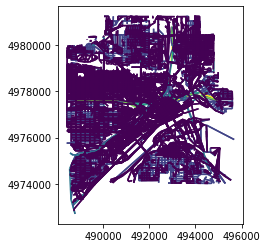

In [130]:
model_road_net.links_metcouncil_df.plot("lanes_AM")

## Export to shapefile

As a last step, the network can be exported to a shapefile and paired CSVs after removing extraneous variables.

(note that this step will also run the `roadway_standard_to_met_council_network()` method but I wanted to show it to you piecewise)

In [ ]:
model_road_net.write_roadway_as_shp(
    output_link_shp = "C:/projects/met_council_git/data/interim/networks/fixed_width/link.shp",
    output_node_shp = "C:/projects/met_council_git/data/interim/networks/fixed_width/node.shp"
)

# Export to fixed width file

In [131]:
model_road_net.write_roadway_as_fixedwidth(
    output_link_txt = "C:/projects/st_paul_link.txt",
    output_node_txt = "C:/projects/st_paul_node.txt",
    output_link_header_width_txt = "C:/projects/st_paul_link_header.csv",
    output_node_header_width_txt = "C:/projects/st_paul_node_header.csv",
    output_cube_network_script = "C:/projects/make_complete_network_from_fixed_width_file.s"
)

2020-03-27 10:22:23, DEBUG: Network Link Variables: 
 - A
 - B
 - HOV
 - access
 - bike_access
 - bike_facility
 - bridge
 - distance
 - drive_access
 - egress
 - geometry
 - lanes
 - locationReferences
 - max_speed
 - model_link_id
 - name
 - osm_link_id
 - price
 - ref
 - roadway
 - shstGeometryId
 - shstReferenceId
 - transit_access
 - trn_priority
 - truck_access
 - ttime_assert
 - tunnel
 - u
 - v
 - walk_access
 - width
 - area_type
 - county
 - centroidconnect
 - mpo
 - assign_group
 - roadway_class
 - AADT
 - ML_lanes
 - segment_id
 - trn_priority_AM
 - trn_priority_MD
 - trn_priority_PM
 - trn_priority_NT
 - ttime_assert_AM
 - ttime_assert_MD
 - ttime_assert_PM
 - ttime_assert_NT
 - lanes_AM
 - lanes_MD
 - lanes_PM
 - lanes_NT
 - ML_lanes_AM
 - ML_lanes_MD
 - ML_lanes_PM
 - ML_lanes_NT
 - price_sov_AM
 - price_hov2_AM
 - price_hov3_AM
 - price_truck_AM
 - price_sov_MD
 - price_hov2_MD
 - price_hov3_MD
 - price_truck_MD
 - price_sov_PM
 - price_hov2_PM
 - price_hov3_PM
 - price

# Write out as MetCouncil Model Transit Network

Similar to the roadway network, the first step is to convert it to a Lasso object, and then write it to a cube line file.  Optionally, you could also export it to a shapefile to inspect using other means. 

In [ ]:
standard_transit = StandardTransit.fromTransitNetwork(my_scenario.transit_net)
standard_transit.feed

Write out the StandardTransit Lasso object to a cube line file:

In [ ]:
standard_transit.write_as_cube_lin()